In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'glaucoma-oct-scans-origa-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2073707%2F3442451%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T091216Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D06aa55b9307c4db655a87fa003bada41a8572ffc696a5823ff38fea99eb0485975081d3da739e7e408b5ff6347e1213af4161ae560993043fc200bd50fbb2b257d29281ff3ae98520e08b3c672ae9759fb4c0b902091fdb4ff394fa9e0eac353ab0302b5d04707bb01ecf343e040a297fbb1a7e4555ff38ad6457e8b4d796f244a09e76a8db9d9d990726b169782079b0cf04c336baa5c72f936e9edfcf7be7b343b832862bb6f44826cbfe7b778c9f21867169f814d9edffce0b4860b2e6e163abf9c2423ebb4695bc7ec98a82382f8f9ae5b0496849b291afc57c5f7940429f90dc33a36782c1e30d93277c58404c6889a8fb675b8c0f40f771eb6da60608d,glaucoma-datasets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2296461%2F3863247%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T091216Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D46c5b3a61729577f1fc597dffc8decb1c04d6043fbe5cb57e85b15c0799857769b6ead4575aa3f5cfbc2f117f5cf6c37a9044934b5fb557f17794ef17336cedb66767e4096f9050a35c1e3653a8342796da14619c5f9fe6a4a26667a91a25934fc3cdc9e3624e9b11e2b074bfeeef24ebe7e86b0607b9514243116518a72f57ee36cf670a87a1a99d3811fc05a99bdadbd72042a82b2a8122b540571e68591a4e43c08b6205f129412f19503e7c3fbd6e2fb0f18da121d4075ab7c6fb74d4e62ff56b373a8cb211b8921d91726a6b4b1dc93390770c3df7ff7603f0733f0cedcc1ff996ad09b890be235a3d6580d74812b6a0c4ca29a491a3f3c9bbe8c1f32be,eyepacs-airogs-light:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3222646%2F5748495%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T091216Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D023252fcfcd1dfc3959ef9746515caf1faa9b4d3433b67d6c20a38939ae32dcea7dc179e9317c8cde8b6f39f7504a71e14204c62e448d085ec9476a8863263e78004dd61782a037e573d67e57e2ecfaeb56561e4a6a898455aa5566c5cdf18b49da763ee23afcdf27eac2cbb57fd6fcbdf11c29b73cad6971f3254dcd969cba59943e4546800a4a145395d0ce7ed3ee35f42d7c921dd89bf054e597f013947167e9c6ff86cd05274351ff8f7099b5de99afcdf018bffa8293f0bb30dd080bcaf1756e6d1d9b096cf01e3241fa14c491c8dd1c592510f06fa1698c9f409d9ab2ddaa080292b454be4f9ab958d7980cce8018686b6a6a1086024d089a507a3be7f,g1020-final:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3880390%2F6738413%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T091216Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D882e274bc81446bf68706eda271d103dd437ed5c89a0968bec17b01f7521a99844b63d1885c6545697635bb053bcbdf6c121fb6443638d6c3f085cb0dd913188b98e70376a9d5352b1b6b90278fb0ff059f871974b649173626dd5c6c5e3cfd9b62ecaf19b57918589c871bbe92f68486f24b3d6cf7ecfdd2428ebefa756e84840f086b5c93ec1e575dc11c44946bdd5fa70420ca7434025f466c4a8949041dc26fbe10a133c91f3503de2d8fc3d395906e51c059beee24559bb9dfbebdee528d77a6a889ffaea6716036a6f576d44f0d652324542051e94ce3f5bd576dd6af3c7c316f3aee2471d713a274fa84a851b1044f9fb75da207f0298fd14add7bd29,fundus-pytorch:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4024114%2F7000210%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T091216Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D944b658b6d651499fdc62a067f78dce4e9971a418a8589dddc515dce59b61bdeca3d0d4746e795dfbacc97726e00e4291479d5c0911a47dbf5e3c83ce286d0b32dd615b8e1dc174579137190ba0256f81ea21301ef2c5a90d0736b94cf2b590d964357585b0fd37800e73e59faf4cd28ea424712a8b5f1b2300130bdccc4197dad781ac3499a7696c6398a371d0d8e03291231021fbc10c2a6073e1ea27c81bdcec2f652060b951d4249147f7b3df2af6ad044207a4deefe242f6cf011eadebd1b83c3c9833f2b1e8b62c69c4efb5adabb2121edb4a9230a7a613f42e9f3e5d0e689234c2ab1df6695e0874c766e77dd300c6fd6ac6c007bd1fba0177b7afbc5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 393642960 bytes downloaded
Downloaded and uncompressed: glaucoma-oct-scans-origa-dataset
[==================================================] 5956275477 bytes downloaded
Downloaded and uncompressed: glaucoma-datasets
[==================================================] 316720067 bytes downloaded
Downloaded and uncompressed: eyepacs-airogs-light
[==================================================] 53799317 bytes downloaded
Downloaded and uncompressed: g1020-final
[==================================================] 4097513970 bytes downloaded
Downloaded and uncompressed: fundus-pytorch
Data source import complete.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


In [ ]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
#from keras import ops
import tensorflow as tf

#import cv2|
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt

## TRAIN, TEST AND VALIDATION DATA COLLECTION(FUNDUS_PYTORCH)

In [ ]:
import os
import pandas as pd

# Directory containing the images
train_dir = "/kaggle/input/fundus-pytorch/train"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(train_dir, subdir)
    print(subdir_path)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))
print(data)

# Create a DataFrame from the list of file paths and labels
df_train = pd.DataFrame(data, columns=["file_path", "label"])
print(df_train)
print(df_train.label.value_counts())

# Save the DataFrame to a CSV file
df_train.to_csv("train.csv", index=False)
# Download the CSV file
from google.colab import files
files.download("train.csv")
#####################################################################################################


# Directory containing the images
test_dir = "/kaggle/input/fundus-pytorch/test"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(test_dir, subdir)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))

# Create a DataFrame from the list of file paths and labels
df_test = pd.DataFrame(data, columns=["file_path", "label"])
print(df_test.label.value_counts())
# Save the DataFrame to a CSV file
df_test.to_csv("test.csv", index=False)
# Download the CSV file
from google.colab import files
files.download("test.csv")
##########################################################################################


# Directory containing the images
valid_dir = "/kaggle/input/fundus-pytorch/val"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["0", "1"]):
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(valid_dir, subdir)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".png"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))

# Create a DataFrame from the list of file paths and labels
df_valid = pd.DataFrame(data, columns=["file_path", "label"])
print(df_valid.label.value_counts())
# Save the DataFrame to a CSV file
df_valid.to_csv("valid.csv", index=False)
# Download the CSV file
from google.colab import files
files.download("valid.csv")

/kaggle/input/fundus-pytorch/train/0
/kaggle/input/fundus-pytorch/train/1
[('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TRAIN-2009.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TRAIN-1700.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TRAIN-3095.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TRAIN-349.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TRAIN-1121.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TRAIN-1408.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TEST-OFFLINE-5.png', 0), ('/kaggle/input/fundus-pytorch/train/0/BEH-451.png', 0), ('/kaggle/input/fundus-pytorch/train/0/JSIEC-1000-14.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TEST-ONLINE-188.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TEST-ONLINE-32.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TRAIN-2161.png', 0), ('/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TRAIN-1315.png', 0), ('/kaggle/input/fundus-pytorch/tra

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

label
0    1754
1    1120
Name: count, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

label
0    3539
1    2208
Name: count, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## GLAUCOMA_DATASET

In [ ]:


# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/glaucoma-datasets/G1020/G1020.csv')
print(df)
# Create a new DataFrame with the image names and labels
df_train1 = pd.DataFrame({
    'file_path': ['/kaggle/input/glaucoma-datasets/G1020/Images/' + image_id for image_id in df['imageID']],
    'label': df['binaryLabels']
})

# Display the first few rows of the new DataFrame
print(df_train1)
print(df_train1.label.value_counts())

df_train1.to_csv("df_train1.csv", index=False)
from google.colab import files
# files.download("df_train1.csv")

             imageID  binaryLabels
0        image_0.jpg             0
1        image_1.jpg             0
2        image_3.jpg             0
3        image_4.jpg             0
4        image_5.jpg             0
...              ...           ...
1015  image_3198.jpg             0
1016  image_3199.jpg             0
1017  image_3201.jpg             1
1018  image_3202.jpg             1
1019  image_2568.jpg             0

[1020 rows x 2 columns]
                                              file_path  label
0     /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
1     /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
2     /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
3     /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
4     /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
...                                                 ...    ...
1015  /kaggle/input/glaucoma-datasets/G1020/Images/i...      0
1016  /kaggle/input/glaucoma-datasets/G1020/Images/

## ORIGA_DATASET

In [ ]:


# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/glaucoma-datasets/ORIGA/OrigaList.csv')

# Create a new DataFrame with the image names and labels
df_train2 = pd.DataFrame({
    'file_path': ['/kaggle/input/glaucoma-datasets/ORIGA/Images/' + image_id for image_id in df['Filename']],
    'label': df['Glaucoma']
})

# Display the first few rows of the new DataFrame
print(df_train2)
print(df_train2.label.value_counts())

df_train2.to_csv("df_train2.csv", index=False)
from google.colab import files
# files.download("df_train2.csv")

                                             file_path  label
0    /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
1    /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
2    /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
3    /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
4    /kaggle/input/glaucoma-datasets/ORIGA/Images/0...      0
..                                                 ...    ...
645  /kaggle/input/glaucoma-datasets/ORIGA/Images/6...      1
646  /kaggle/input/glaucoma-datasets/ORIGA/Images/6...      1
647  /kaggle/input/glaucoma-datasets/ORIGA/Images/6...      1
648  /kaggle/input/glaucoma-datasets/ORIGA/Images/6...      0
649  /kaggle/input/glaucoma-datasets/ORIGA/Images/6...      1

[650 rows x 2 columns]
label
0    482
1    168
Name: count, dtype: int64


### GLUACOMA_OCT_SCANA_ORIGA_DATASET

In [ ]:
import os
import pandas as pd

# Directory containing the images
train_dir = "/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["yes"], start=1):  # Start from 1
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(train_dir, subdir)
    print(subdir_path)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".jpg"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))
print(data)
# Create a DataFrame from the list of file paths and labels
df_train3 = pd.DataFrame(data, columns=["file_path", "label"])
print(df_train3)
print(df_train3.label.value_counts())

# Save the DataFrame to a CSV file
df_train3.to_csv("df_train3.csv", index=False)
from google.colab import files
# files.download("df_train3.csv")

/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes
[('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/304.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/556.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/457.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/317.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/609.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/213.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/593.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/294.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/087.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/578.jpg', 1), ('/kaggle/input/glaucoma-oct-scans-origa-dataset/dataset/dataset/yes/523.jpg', 1), ('/kaggle/input/gla

### G1020_FINAL

In [ ]:
import os
import pandas as pd

# Directory containing the images
train_dir = "/kaggle/input/g1020-final/G1020"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["glucoma"], start=1):  # Start from 1
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(train_dir, subdir)
    print(subdir_path)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".jpg"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))
print(data)
# Create a DataFrame from the list of file paths and labels
df_train4 = pd.DataFrame(data, columns=["file_path", "label"])
print(df_train4)
print(df_train4.label.value_counts())

# Save the DataFrame to a CSV file
df_train4.to_csv("df_train4.csv", index=False)
# from google.colab import files
# files.download("df_train4.csv")

/kaggle/input/g1020-final/G1020/glucoma
[('/kaggle/input/g1020-final/G1020/glucoma/image_2050.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_2146.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_1338.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_360.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_1788.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_1796.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_807.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_773.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_1112.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_1799.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_2033.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_199.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_2148.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_1201.jpg', 1), ('/kaggle/input/g1020-final/G1020/glucoma/image_2404.jpg', 1), ('/kaggle/input/g1

### EYEPACS_AIROGS_LIGHT_ DATASET

In [ ]:
import os
import pandas as pd

# Directory containing the images
train_dir = "/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train"

# List to store the file paths and labels
data = []

# Iterate over the subdirectories 0 and 1
for label, subdir in enumerate(["RG"], start=1):  # Start from 1
    # Get the full path of the current subdirectory
    subdir_path = os.path.join(train_dir, subdir)
    print(subdir_path)
    # Iterate over the files in the subdirectory
    for filename in os.listdir(subdir_path):
        # Check if the file has a .png extension
        if filename.endswith(".jpg"):
            # Create the full path of the file
            file_path = os.path.join(subdir_path, filename)
            # Append the file path and label to the list
            data.append((file_path, label))
print(data)
# Create a DataFrame from the list of file paths and labels
df_train5 = pd.DataFrame(data, columns=["file_path", "label"])
print(df_train5)
print(df_train5.label.value_counts())

# Save the DataFrame to a CSV file
df_train5.to_csv("df_train5.csv", index=False)
# files.download("df_train5.csv")

/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG
[('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-190.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-435.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-1534.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-51.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-1677.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-889.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-1498.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-2313.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePACS-RG-6.jpg', 1), ('/kaggle/input/eyepacs-airogs-light/release-raw/release-raw/train/RG/EyePA

In [ ]:
import pandas as pd

# Assuming df_train and df_train1 are already defined

# Stack the dataframes
df_train = pd.concat([df_train, df_train1, df_train2, df_train3, df_train4, df_train5], ignore_index=True)

# Display the first few rows of the new DataFrame
print(df_train)
print(df_train.label.value_counts())
df_train.to_csv("train_final.csv", index=False)
files.download("train_final.csv")

                                               file_path  label
0      /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
1      /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
2      /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
3      /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
4      /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
...                                                  ...    ...
13238  /kaggle/input/eyepacs-airogs-light/release-raw...      1
13239  /kaggle/input/eyepacs-airogs-light/release-raw...      1
13240  /kaggle/input/eyepacs-airogs-light/release-raw...      1
13241  /kaggle/input/eyepacs-airogs-light/release-raw...      1
13242  /kaggle/input/eyepacs-airogs-light/release-raw...      1

[13243 rows x 2 columns]
label
1    6744
0    6499
Name: count, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_train.label.value_counts()

label
1    6744
0    6499
Name: count, dtype: int64

## RESIZING THE IMAGES

In [ ]:
# import cv2
# # Create a new directory in /kaggle/working/
# new_directory = '/kaggle/working/resized_images'
# os.makedirs(new_directory, exist_ok=True)

# # Initialize a list to store the resized file paths
# resized_file_paths = []

# # Loop through each row in df_train
# for index, row in df_train.iterrows():
#     # Load the image
#     image = cv2.imread(row['file_path'])
#     # Check if the image is None
#     if image is None:
#         print(f"Failed to read image: {row['file_path']}")
#     else:
#         # Resize the image to 512x512
#         resized_image = cv2.resize(image, (512, 512))
#         # Generate a new file path for the resized image
#         resized_file_path = f'{new_directory}/{row["file_path"].split("/")[-1][:-4]}_resized.png'
#         # Save the resized image to the new file path
#         cv2.imwrite(resized_file_path, resized_image)
#         # Append the new file path to the list
#         resized_file_paths.append(resized_file_path)

# # Update the 'file_path' column in df_train with the new file paths
# df_train['file_path'] = resized_file_paths

# # Print the first few rows of df_train to verify the changes
# print(df_train.head())

In [ ]:
df_train.head()

file_path  label
0  /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
1  /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
2  /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
3  /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...      0
4  /kaggle/input/fundus-pytorch/train/0/REFUGE1-v...      0

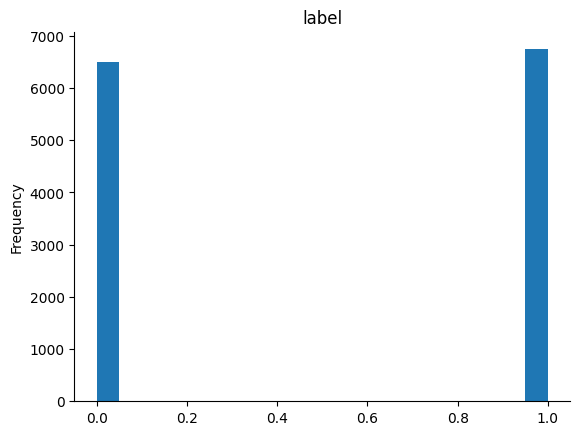

In [ ]:
# @title label

from matplotlib import pyplot as plt
df_train['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

## REGION OF INTEREST EXTRACTION

790    /kaggle/input/glaucoma-datasets/G1020/Images/i...
501    /kaggle/input/glaucoma-datasets/G1020/Images/i...
716    /kaggle/input/glaucoma-datasets/G1020/Images/i...
206    /kaggle/input/glaucoma-datasets/G1020/Images/i...
83     /kaggle/input/glaucoma-datasets/G1020/Images/i...
396    /kaggle/input/glaucoma-datasets/G1020/Images/i...
Name: file_path, dtype: object
/kaggle/input/glaucoma-datasets/G1020/Images/image_1580.jpg
x, y:  2083 1239


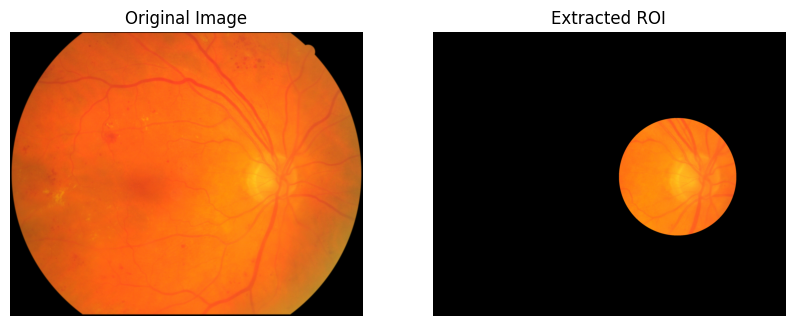

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = df_train1["file_path"].sample().values[0]
print(df_train1["file_path"].sample(n=6))
print(df_train1["file_path"].sample(n=6).values[1])
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

# Find the pixel with the highest intensity value
max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

# Define the radius for the circle
radius = 1000 // 2

# Get the x and y coordinates for cropping the image
x = max_intensity_pixel[1]
y = max_intensity_pixel[0]
print("x, y: ", x, y)
# Create a mask for the circle
mask = np.zeros_like(image)
cv2.circle(mask, (x, y), radius, (255, 255, 255), -1)

# Apply the mask to the original image
roi_image = cv2.bitwise_and(image, mask)

# Plot the original image and the extracted ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted ROI')
plt.axis('off')

plt.show()



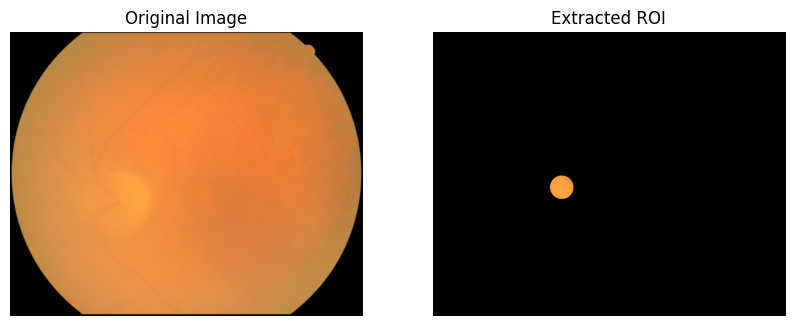

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = df_train["file_path"].sample().values[0]

# Check the file extension
file_extension = os.path.splitext(image_path)[1]

# Load the image based on the file extension
if file_extension.lower() == '.png':
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
else:
    image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

# Find the pixel with the highest intensity value
max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

# Define the radius for the circle
radius = 200 // 2

# Get the x and y coordinates for cropping the image
x = max_intensity_pixel[1] - radius
y = max_intensity_pixel[0] - radius

# Create a mask for the circle
mask = np.zeros_like(image)
cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)

# Apply the mask to the original image
roi_image = cv2.bitwise_and(image, mask)

# Plot the original image and the extracted ROI
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted ROI')
plt.axis('off')

plt.show()


## PERFORM ROI ON THE DATA

In [ ]:
# import cv2
# import numpy as np
# import os
# import pandas as pd

# def extract_rois_and_labels(df, output_dir):
#     # Create the output directory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)

#     # Initialize an empty list to store the rows of the DataFrame
#     roi_rows = []

#     for index, row in df.iterrows():
#         # Load the image
#         image = cv2.imread(row['file_path'])

#         # Convert the image to grayscale
#         gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#         # Apply Gaussian blur
#         blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

#         # Find the pixel with the highest intensity value
#         max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

#         # Define the radius for the circle
#         radius = 200 // 2

#         # Get the x and y coordinates for cropping the image
#         x = max_intensity_pixel[1] - radius
#         y = max_intensity_pixel[0] - radius

#         # Create a mask for the circle
#         mask = np.zeros_like(image)
#         cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)

#         # Apply the mask to the original image
#         roi_image = cv2.bitwise_and(image, mask)

#         # Split the green channel
#         green_channel = roi_image[:, :, 1]
#         # Apply histogram equalization
#         clahe_op = cv2.createCLAHE(clipLimit=2)
#         roi_image = clahe_op.apply(green_channel)

#         # Save the ROI image
#         roi_filename = os.path.basename(row['file_path']).split('.')[0] + '_roi.jpg'
#         roi_path = os.path.join(output_dir, roi_filename)
#         cv2.imwrite(roi_path, roi_image)

#         # Append the row to the list
#         roi_rows.append({'roi_path': roi_path, 'label': row['label']})

#     # Create a DataFrame from the list of rows
#     roi_df = pd.DataFrame(roi_rows)

#     return roi_df




###### PROCESSOR INTENSIVE CODE

### PERFORM RESIZING , ROI AND GRAYSCALING

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd

def extract_rois_and_labels(df, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize an empty list to store the rows of the DataFrame
    roi_rows = []

    for index, row in df.iterrows():
        # Load the image
        image = cv2.imread(row['file_path'])

        # Resize the image to 512x512
        resized_image = cv2.resize(image, (512, 512))

        # Convert the resized image to grayscale
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

        # Find the pixel with the highest intensity value
        max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

        # Define the radius for the circle
        radius = 200 // 2

        # Get the x and y coordinates for cropping the image
        x = max_intensity_pixel[1] - radius
        y = max_intensity_pixel[0] - radius

        # Create a mask for the circle
        mask = np.zeros_like(resized_image)
        cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)

        # Apply the mask to the resized image
        roi_image = cv2.bitwise_and(resized_image, mask)

        # Split the green channel
        green_channel = roi_image[:, :, 1]
        # Apply histogram equalization
        clahe_op = cv2.createCLAHE(clipLimit=2)
        roi_image = clahe_op.apply(green_channel)

        # Save the ROI image
        roi_filename = os.path.splitext(os.path.basename(row['file_path']))[0]
        roi_filename = roi_filename + '_roi.jpg'
        roi_path = os.path.join(output_dir, roi_filename)
        cv2.imwrite(roi_path, roi_image)

        # Append the row to the list
        roi_rows.append({'roi_path': roi_path, 'label': row['label']})

    # Create a DataFrame from the list of rows
    roi_df = pd.DataFrame(roi_rows)

    return roi_df


In [ ]:
# Extract ROIs and labels for the training images
train_roi_df = extract_rois_and_labels(df_train, 'train_roi_images')
print(train_roi_df)
# Extract ROIs and labels for the testing images
test_roi_df = extract_rois_and_labels(df_test, 'test_roi_images')
print(test_roi_df)
# Extract ROIs and labels for the validation images
valid_roi_df = extract_rois_and_labels(df_valid, 'valid_roi_images')
print(valid_roi_df)

In [ ]:
def image_cvt_histeq(df, target_path):
    # Create the target directory if it doesn't exist
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    new_df = pd.DataFrame(columns=['file_path', 'label'])

    for index, row in df.iterrows():
        # Load the image
        img = cv2.imread(row['file_path'])
        # Split the green channel
        green_channel = img[:, :, 1]
        # Apply histogram equalization
        clahe_op = cv2.createCLAHE(clipLimit=2)
        final_img = clahe_op.apply(green_channel)
        # Save the image
        cv2.imwrite(os.path.join(target_path, f'{index}.png'), final_img)
        # Add the new file path and label to the new DataFrame
        new_df = new_df.append({'file_path': os.path.join(target_path, f'{index}.png'), 'label': row['label']}, ignore_index=True)

    return new_df


###### PLOT OF THE NEW DATAFRAMES

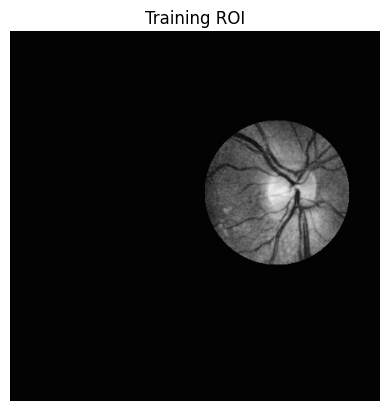

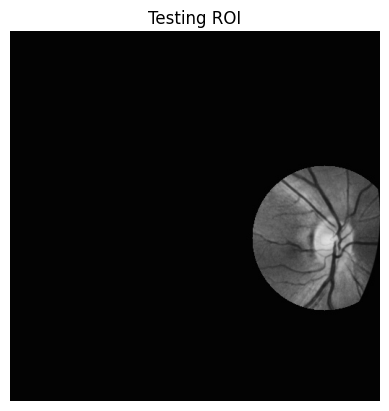

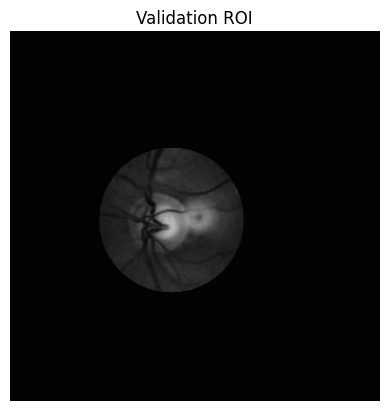

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to plot a random image from a DataFrame
def plot_random_image(df, title):
    # Get a random row from the DataFrame-
    random_row = df.sample()

    # Load the image
    image_path = random_row['roi_path'].values[0]
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot a random image from each DataFrame
plot_random_image(train_roi_df, 'Training ROI')
plot_random_image(test_roi_df, 'Testing ROI')
plot_random_image(valid_roi_df, 'Validation ROI')


In [ ]:
train_roi_df.label.count()

13243

# DATA PREPROCESSING

In [ ]:
# Convert the label column to strings
train_roi_df["label"] = train_roi_df["label"].astype(str)
test_roi_df["label"] = test_roi_df["label"].astype(str)
valid_roi_df["label"] = valid_roi_df["label"].astype(str)

In [ ]:
test_roi_df.label.value_counts()

label
0    1754
1    1120
Name: count, dtype: int64

In [ ]:
train_roi_df["label"].value_counts()

label
1    6744
0    6499
Name: count, dtype: int64

In [ ]:
def custom_preprocessing(image):
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(gray_image, (65, 65), 0)

        # Find the pixel with the highest intensity value
        max_intensity_pixel = np.unravel_index(np.argmax(blurred_image), blurred_image.shape)

        # Define the radius for the circle
        radius = 200 // 2

        # Get the x and y coordinates for cropping the image
        x = max_intensity_pixel[1] - radius
        y = max_intensity_pixel[0] - radius

        # Create a mask for the circle
        mask = np.zeros_like(image)
        cv2.circle(mask, (x + radius, y + radius), radius, (255, 255, 255), -1)

        # Apply the mask to the original image
        roi_image = cv2.bitwise_and(image, mask)

        # Split the green channel
        green_channel = roi_image[:, :, 1]
        # Apply histogram equalization
        clahe_op = cv2.createCLAHE(clipLimit=2)
        roi_image = clahe_op.apply(green_channel)

        return roi_image


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',

)

# Define the data generator for validation images
valid_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create the training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Create the validation data generator
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
)

# Define the data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_roi_df,
    x_col='roi_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)


Found 13243 validated image filenames belonging to 2 classes.
Found 5747 validated image filenames belonging to 2 classes.
Found 2874 validated image filenames belonging to 2 classes.


## BUILDING U_NET ARCHITECTURE

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.metrics import AUC

# def build_unet_model(input_shape):
#     inputs = tf.keras.Input(shape=input_shape)

#     # Encoder
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#     # Bottleneck
#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

#     # Decoder
#     up4 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
#     merge4 = layers.concatenate([conv2, up4], axis=3)
#     conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
#     conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

#     up5 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
#     merge5 = layers.concatenate([conv1, up5], axis=3)
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

#     # Output
#     outputs = layers.Dense(1, activation='sigmoid')(conv5)


#     model = tf.keras.Model(inputs=inputs, outputs=outputs, name="U-Net")

#     return model

# # Create the U-Net model
# unet_model = build_unet_model(input_shape=(256, 256, 3))

# # Compile the model with SGD optimizer
# sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# unet_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=[AUC()],)

In [ ]:
# unet_model.summary()

In [ ]:
# tf.keras.utils.plot_model(unet_model, show_shapes=True)

### BUILDING NORMAL CNN ARCHITECTURE

In [ ]:

import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import Loss

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
#     Dropout(0.5),  # Add dropout layer
    Dense(1, activation='sigmoid')
])
# NO DROPOUT LAYER FOR 0.83

sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, #LEARNING RATE TO 0.01 FOR 0.83
                                        momentum=0.9)
# unet_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=[AUC()],)


class FocalLoss(Loss):
    def __init__(self, alpha=0.65, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Calculate binary cross-entropy loss
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)

        # Calculate focal loss
        pt = tf.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        # Calculate class weights
        class_weights = tf.constant([1.0, 1.0])  # Initialize with equal weights
        total_samples = tf.reduce_sum(y_true)
        class_weights = total_samples / (2.0 * tf.reduce_sum(y_true, axis=0))

        # Apply class weights to the focal loss
        focal_loss = focal_loss * class_weights

        return focal_loss


model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])

# # Compile the model
# model.compile(optimizer=sgd_optimizer,
#               loss=FocalLoss(),
#               metrics=[AUC()])

#CHANGE TO AUC FOR 0.83

#### IMAGE NET

In [ ]:
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import keras
import numpy as np
import random
import shutil

In [ ]:
# from keras.layers import GlobalMaxPool2D
# target = 256
# # simple model that uses mobilenet background
# def getModel(image_size, num_classes):
#     model_input = keras.Input(shape=(image_size, image_size, 3))

#     transfer = keras.applications.MobileNetV3Large(
#         weights='imagenet', include_top=False, input_tensor=model_input
#     )
#     x = transfer.get_layer(index=142).output

#     x = SpatialDropout2D(0.15)(x)
#     x = Conv2D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
#     x = GlobalMaxPool2D()(x)
#     x = Dropout(0.15)(x)

#     model_output = Dense(1, activation='sigmoid') (x)

#     return keras.Model(inputs=model_input, outputs=model_output)

# model = getModel(image_size=target, num_classes=1)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath='val-best.h5',
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

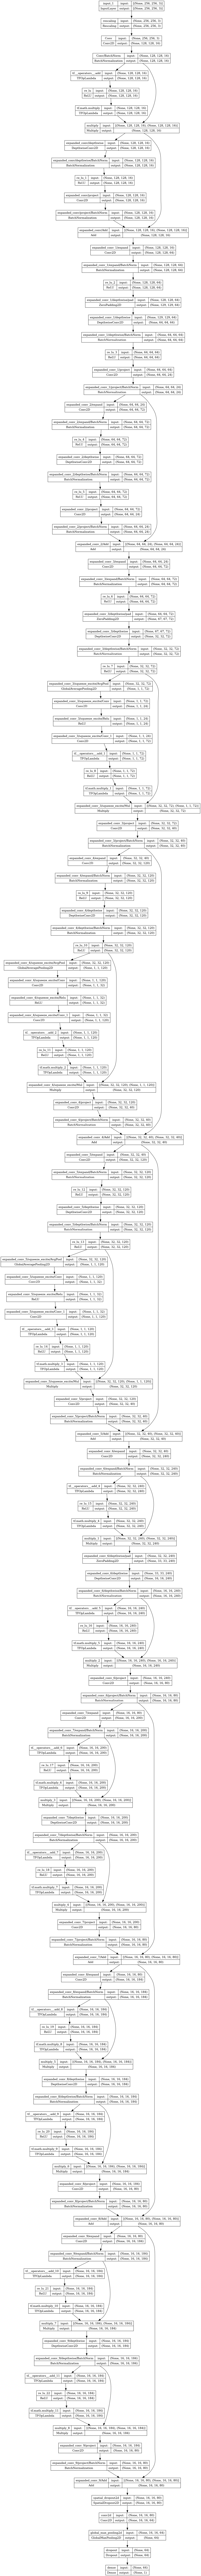

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])

###### DEALING WITH CLASS IMBALANCE AND OVER FITTING

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-3)


In [ ]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    shuffle=True,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
414/414 [==============================] - 54s 119ms/step - loss: 0.6431 - binary_accuracy: 0.6262 - auc_2: 0.6760 - precision_2: 0.6430 - recall_2: 0.5980 - val_loss: 0.6611 - val_binary_accuracy: 0.6148 - val_auc_2: 0.6816 - val_precision_2: 0.4990 - val_recall_2: 0.6993 - lr: 1.0000e-04
Epoch 2/30
414/414 [==============================] - 46s 112ms/step - loss: 0.5763 - binary_accuracy: 0.6891 - auc_2: 0.7595 - precision_2: 0.7105 - recall_2: 0.6575 - val_loss: 0.6007 - val_binary_accuracy: 0.6882 - val_auc_2: 0.7095 - val_precision_2: 0.6492 - val_recall_2: 0.4099 - lr: 1.0000e-04
Epoch 3/30
414/414 [==============================] - 49s 118ms/step - loss: 0.5434 - binary_accuracy: 0.7152 - auc_2: 0.7907 - precision_2: 0.7405 - recall_2: 0.6785 - val_loss: 0.5714 - val_binary_accuracy: 0.7087 - val_auc_2: 0.7512 - val_precision_2: 0.6336 - val_recall_2: 0.5734 - lr: 1.0000e-04
Epoch 4/30
414/414 [==============================] - 47s 112ms/step - loss: 0.5192 - binary_a

# MODEL EVALUATION

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc,_,i,a = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc}")

90/90 [==============================] - 7s 77ms/step - loss: 0.2438 - binary_accuracy: 0.9001 - auc_2: 0.9629 - precision_2: 0.8818 - recall_2: 0.8589
Test accuracy: 0.9001391530036926


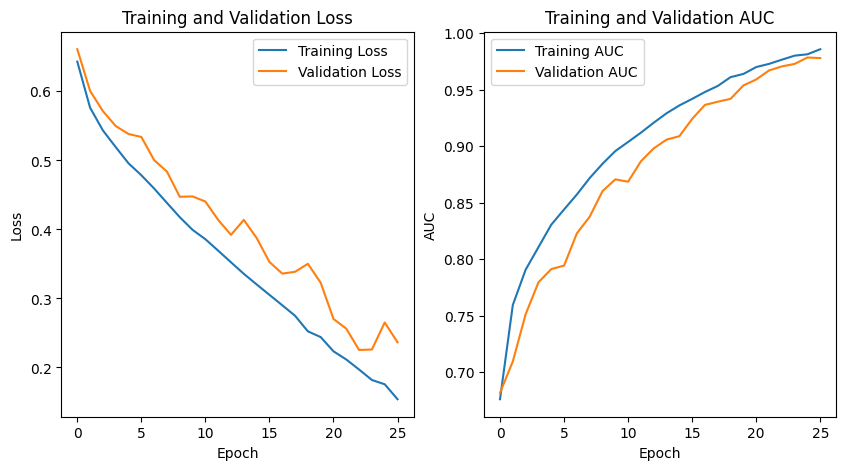

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss and AUC scores from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc_2']
val_auc = history.history['val_auc_2']

# Create a plot of the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Create a plot of the training and validation AUC scores
plt.subplot(1, 2, 2)
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.show()


90/90 [==============================] - 6s 67ms/step


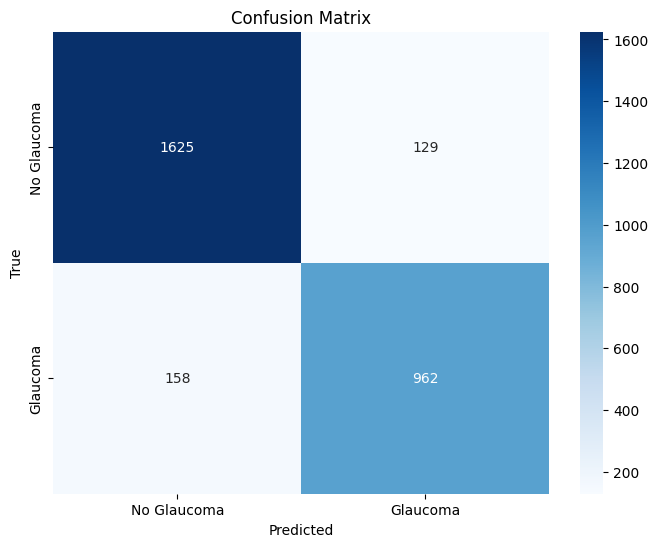

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)

# Convert the predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Glaucoma', 'Glaucoma'], yticklabels=['No Glaucoma', 'Glaucoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Calculate the area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# SAVE MODEL

In [ ]:
model.save('GLAUCOMA_DETECTION.h5')

#